In [63]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [67]:
X = pd.read_csv('../data/x_train.txt', sep=' ', header=None)

y = pd.read_csv('../data/y_train.txt', sep=' ', header=None)

In [68]:
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

y_n = np.ravel(y)
X_n = X.values

X_n = StandardScaler().fit_transform(X_n)

## Correlation matrix

In [69]:
correlation_matrix = pd.DataFrame(X_n).corr()

high_corr_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_features.add(correlation_matrix.columns[i])
            high_corr_features.add(correlation_matrix.columns[j])


high_corr_features_list = list(high_corr_features)
print(high_corr_features_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


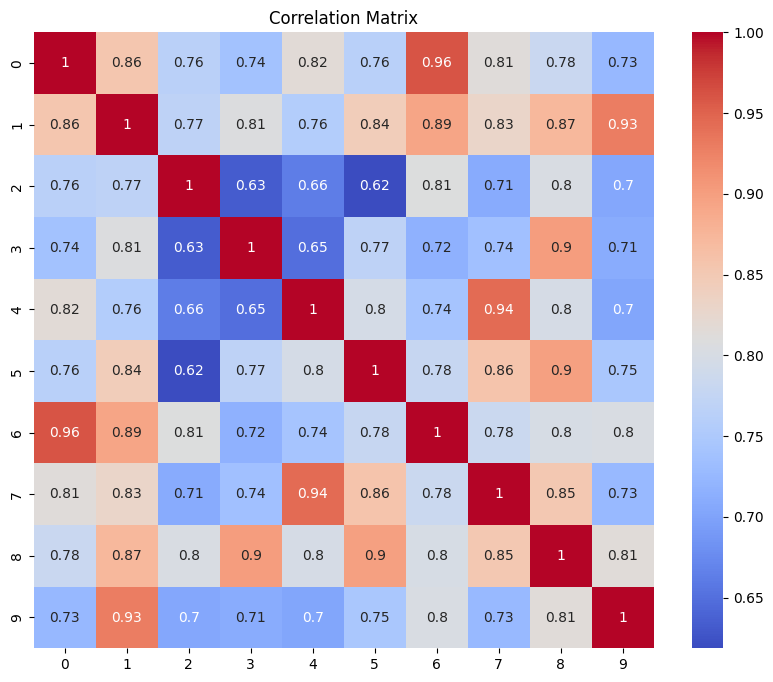

In [70]:
corr_matrix_2 = X_n.loc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [71]:
high_corr_features_list.remove(0)
high_corr_features_list

[1, 2, 3, 4, 5, 6, 7, 8, 9]

## Boruta

In [4]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=33)

feat_selector.fit(X_n, y_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	483
Iteration: 	9 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	483
Iteration: 	10 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	483
Iteration: 	11 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	483
Iteration: 	12 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	483
Iteration: 	13 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	483
Iteration: 	14 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	483
Iteration: 	15 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	483
Iteration: 	16 / 100
Confirmed: 	16
Tenta

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=116, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F9E101F8940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F9E101F8940, verbose=2)

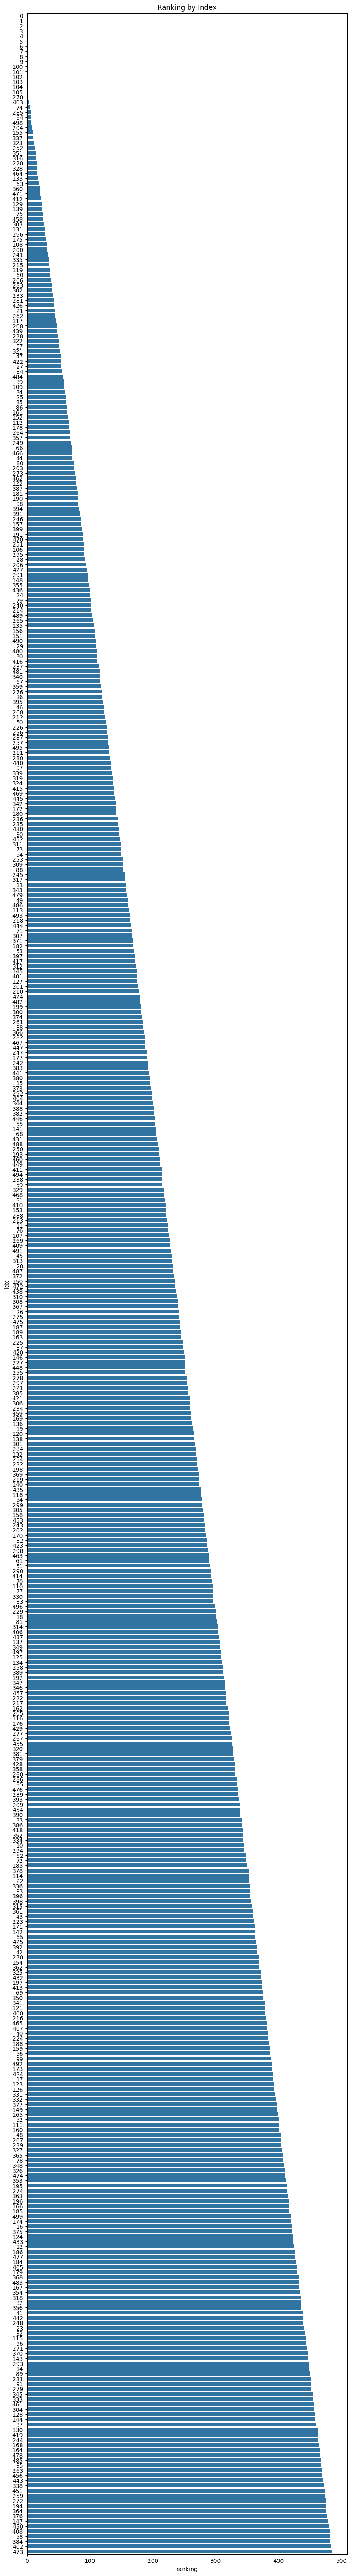

In [5]:
ranking = feat_selector.ranking_

indices = np.arange(len(ranking))

df = pd.DataFrame({
    'idx': indices,
    'ranking': ranking
})

df_sorted = df.sort_values('ranking')

plt.figure(figsize=(10, 80))
sns.barplot(x='ranking', y='idx', data=df, order=df_sorted['idx'], orient='h')
plt.title('Ranking by Index')
plt.show()

In [6]:
top_50_features = df_sorted.head(50)['idx'].reset_index(drop=True).to_numpy()
top_50_features

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 100, 101, 102,
       103, 104, 105, 270, 403,  74, 285,  64, 498, 204, 155, 337, 323,
       252, 351, 316, 220, 328, 464, 133,  63, 360, 471, 412, 129, 139,
        75, 458, 303, 131, 296, 175, 108, 200, 241, 335, 215])

In [73]:
X_filtered = X.iloc[:, top_50_features]
X_filtered = X_filtered.drop(columns=high_corr_features_list)

## XGBoost

In [74]:
from matplotlib import pyplot
from xgboost import XGBClassifier, plot_importance

model = XGBClassifier()
fitxgb= model.fit(pd.DataFrame(X_n).drop(columns=high_corr_features_list), y_n)

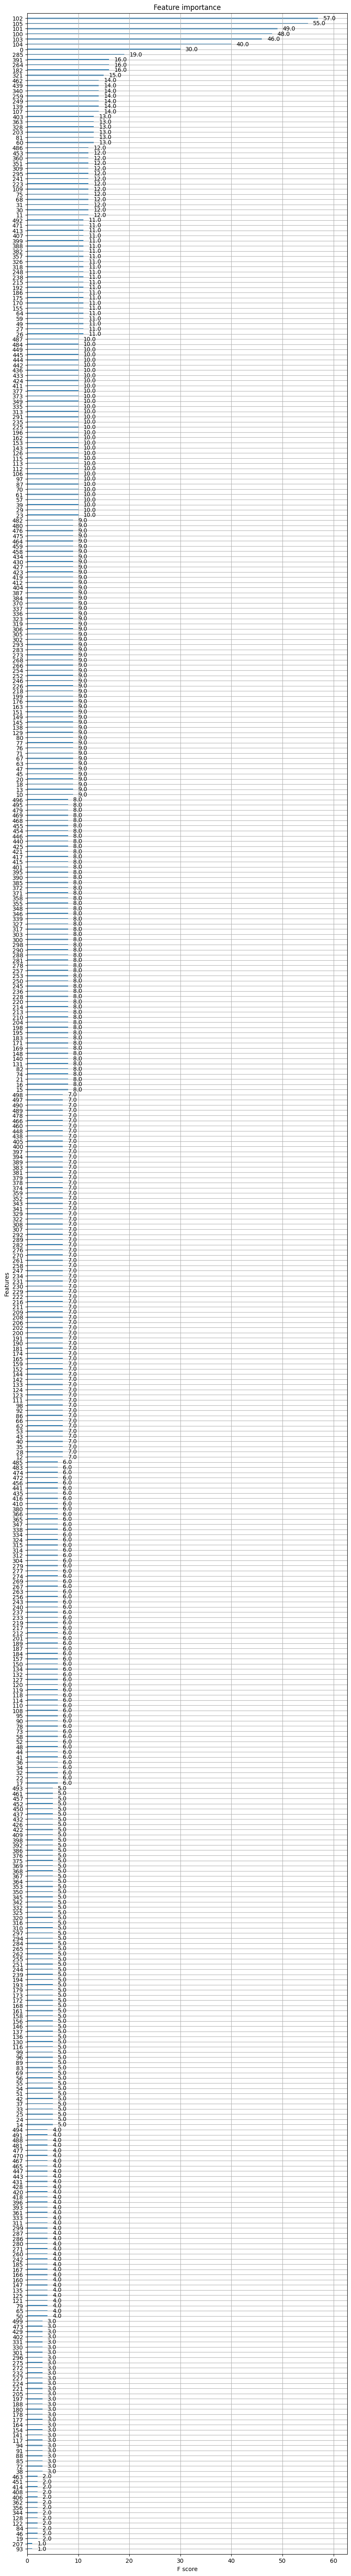

In [75]:
fig, ax = pyplot.subplots(figsize=(10, 80))
plot_importance(model, ax=ax, importance_type='weight')
pyplot.show()

In [76]:
# Your dictionary
data = fitxgb.get_booster().get_fscore()
# Convert to DataFrame
df = pd.DataFrame(list(data.items()), columns=['idx', 'ranking'])

df['idx'] = df['idx'].astype(int)

# Sort by 'idx'
df = df.sort_values('ranking', ascending=False)

In [77]:
top_10_xgb = df.head(10)['idx'].reset_index(drop=True).to_numpy()
top_10_xgb

array([102, 105, 101, 100, 103, 104,   0, 285, 391, 182])

## Boruta + RFE-SVM

In [40]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

svc = SVC(kernel="linear")
rfecv = RFE(estimator=svc, step=1, n_features_to_select=1, verbose=3)
rfecv.fit(X_filtered, y_n)

Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 fe

RFE(estimator=SVC(kernel='linear'), n_features_to_select=1, verbose=3)

In [41]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Ranking of features : %s" % rfecv.ranking_)
print("Selected features : %s" % rfecv.support_)

Optimal number of features : 1
Ranking of features : [32 34 41 20 25 26 22 24 31 28  1 19 33 10 16 13  3  6  7 11  5  9 40 30
 39  8 38 36 35 29 17 37  4 27 14 18 23 15 21  2 12]
Selected features : [False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]


In [45]:
top_10_svm = X_filtered.columns[rfecv.ranking_ - 1][:10]
top_10_svm

Index([458, 131, 215, 316, 63, 360, 328, 133, 75, 412], dtype='int64')

## Boruta + SFS

In [46]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=5000, penalty='l1', solver='liblinear')

sfs = SequentialFeatureSelector(lr, n_features_to_select=10, direction='forward', cv=5)
sfs.fit(X_filtered, y_n)

SequentialFeatureSelector(estimator=LogisticRegression(max_iter=5000,
                                                       penalty='l1',
                                                       solver='liblinear'),
                          n_features_to_select=10)

In [47]:
top_10_sfs = X_filtered.columns[sfs.get_support()][:10]
top_10_sfs

Index([101, 403, 285, 155, 337, 471, 412, 131, 241, 335], dtype='int64')

## Boruta + MI

In [79]:
from sklearn.feature_selection import mutual_info_classif

# Compute the mutual information between each feature and the target
mi = mutual_info_classif(X_filtered, y_n, random_state=33)

# Create a DataFrame
mi_df = pd.DataFrame({
    'feature': X_filtered.columns,
    'mi': mi
})

# Sort DataFrame by mutual information in descending order
mi_df = mi_df.sort_values('mi', ascending=False)

top_10_mi = mi_df.head(10)['feature'].reset_index(drop=True).to_numpy()
top_10_mi

array([101, 296, 328, 103, 412, 105,   0, 131, 351, 323])